In [1]:
import numpy as np
import math as math
import cmath as cmath
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import quad
import cmath
from math import isnan
from scipy.optimize import bisect
from scipy.stats import norm

# Generate Data

In [ ]:
#Class of Heston Stochastic Volatility Model
#Using Euler Discretization and Milstein Discretization
import numpy as np
from numpy.random import standard_normal

class HestonModel: 
    def __init__(self, nSteps, nPaths, s0, v0, r,theta, kappa, lamda, rho):
        self._nSteps = nSteps
        self._nPaths = nPaths
        #Initial stock price
        self._s0 = s0
        #Initial volatility
        self._v0 = v0
        #risk free rate
        self._r = r
        #long term volatility(equiribrium level)
        self._theta = theta
        #Mean reversion speed of volatility
        self._kappa = kappa
        #lambda(volatility of Volatility)
        self._lamda = lamda
        #rho
        self._rho = rho
        
    #Euler Discretization
    def _generate_path(self, dt):
        s = np.zeros(self._nSteps + 1)
        v = np.zeros(self._nSteps + 1)
        s[0] = self._s0            
        v[0] = self._v0
        dW1 = standard_normal(self._nSteps)
        dW2 = self._rho * dW1 + (1 - self._rho**2)**(0.5) * standard_normal(self._nSteps)
        for j in range(0, self._nSteps):
            s[j + 1] = s[j] * np.exp((self._r - 0.5 * v[j]) * dt + (v[j] * dt)**(0.5) * dW1[j])
            v[j + 1] = max(v[j] + (self._kappa * (self._theta - v[j]) * dt) + self._lamda * (v[j] * dt)**(0.5) * dW2[j], 0)
        return s
    #Milstein Discretization
    def _generate_path_Mil(self, dt):
        s = np.zeros(self._nSteps + 1)
        v = np.zeros(self._nSteps + 1)
        s[0] = self._s0            
        v[0] = self._v0
        dW1 = standard_normal(self._nSteps)
        dW2 = self._rho * dW1 + (1 - self._rho**2)**(0.5) * standard_normal(self._nSteps)
        for j in range(0, self._nSteps):
            s[j + 1] = s[j] * np.exp((self._r - 0.5 * v[j]) * dt + (v[j] * dt)**(0.5) * dW1[j])
            v[j + 1] = max((self._kappa*(self._theta - v[j])*dt)-(0.25*(self._lamda**2)*dt)+\
                       (v[j]**0.5+0.5*self._lamda*dW2[j]*(dt**(0.5)))**2, 0)
        return s            
    #Pricing with Euler Discretization
    def price(self, option):
        payOff_Sum = 0.0
        for i in range(0, self._nPaths):
            payOff_Sum += option.payoff(self._generate_path(option.T / self._nSteps))
        return (np.exp(- self._r * option.T) * payOff_Sum / self._nPaths)
    #Pricing with Milstein Discretization
    def price_Mil(self, option):
        payOff_Sum = 0.0
        for i in range(0, self._nPaths):
            payOff_Sum += option.payoff(self._generate_path_Mil(option.T / self._nSteps))
        return (np.exp(- self._r * option.T) * payOff_Sum / self._nPaths)
class Option : 
    def __init__(self, K, T):
        self.K = K
        self.T = T
    def payoff(self, underlying_path):
        pass
#Call Option class
class CallOption(Option):
    def payoff(self, underlying_path):
        return max(underlying_path[-1] - self.K, 0)
#Put Option class
class PutOption(Option):
    def payoff(self, underlying_path):
        return max(self.K - underlying_path[-1], 0)
    


#Black Scholes Function
def BS(S, K, T, r, v, callPutFlag = 'c'):
    d1 = (np.log(S / K) + (r + 0.5 * v**2) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    if (callPutFlag == 'c') or (callPutFlag == 'C'):
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
#Calc Vega    
def BS_vega(S, K, T, r, v):
    d1 = (np.log(S/K)+(r+0.5*v**2)*T)/(v*np.sqrt(T))
    return (S*np.sqrt(T)*si.norm.cdf(d1))
#Calc Implied volatility using Newton's Method
def IV(price_, S, K, T, r, max_it = 300, callPutFlag = 'c'):
    pre = 1.0e-5
    v = 0.2
    for i in range(max_it):
        price = BS(S, K, T, r, v, callPutFlag = 'c')
        vega = BS_vega(S, K, T, r, v)
        price = price 
        diff = price_ - price
        if (abs(diff)<pre):
            return v
        v = v + diff/vega
    #return best vol
    return v    

In [ ]:
class Heston(object):
    
    def __init__(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): #Constructor for initiating the class
        
        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;
   
        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];
        
    def reset_parameters(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): # Function for resetting the constant parameters
        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;
   
        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];       
       
    
    def characteristic_func(self,phi):#Return the characteristic functions f1 and f2, each of which has a real and a complex part
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        for j in range(2):

            temp=self.b[j]-1j*self.rho*self.sigma*phi;

            d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));

            g[j]=(temp+d[j])/(temp-d[j]);

            edt[j]=cmath.exp(d[j]*self.tau);
            gedt[j]=1.0-g[j]*edt[j];

            D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
            C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
            f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);     
            
        return f;    
 
    def f1(self,phi):#f1 only using a copy of the previous code with minimal change, i.e.,j=0 replaes loop
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=0;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);

        return f[0];    
    
    def f2(self,phi):# f2 only using a copy of the previous code with minimal change, i.e.,now j=1 replaes loop
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=1;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);
        
        return f[1];     
      
    def P1_integrand(self,phi): #Returns the integrand  that appears in the P1 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f1(phi)/1j/phi;
        return temp.real;

    def P2_integrand(self,phi):  #Returns the integrand  that appears in the P1 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f2(phi)/1j/phi;
        return temp.real;
    
    def Probabilities(self,a,b,n):  #Compute the two probabilities: a and b are the integration limits, n is the number of intervals
                                    # usually the interval >0 to 100 captures the range that matters, so no need to go to b=infinity!
        pi_i=1.0/math.pi;
        P1=0.5+pi_i*trapzd(self.P1_integrand,a,b,n); #trapzd function is de
        P2=0.5+pi_i*trapzd(self.P2_integrand,a,b,n);
        P=[P1,P2];
        return P;
    
    def price(self,a,b,n):
        Ps=self.Probabilities(a,b,n);
        
        call_price=math.exp(self.x0)*Ps[0]-math.exp(self.ln_k-self.r*self.tau)*Ps[1];
        put_price=call_price-(math.exp(self.x0)-math.exp(self.ln_k-self.r*self.tau));
        
        output={
            "Call price":call_price,
            "Put price":put_price,
            "P1":Ps[0],
            "P2":Ps[1]
        }
        return output;
    
    def plot_f1f2(self): # Plot real parts of the characteristic functions (f1 and f2), 
                         # and the integrands that appear in P1 and P2
        
        n=2000;
        lwr=-50.111;
        upr=50.0311;
        
        x=np.linspace(lwr,upr,n+1);
        fs=[self.characteristic_func(x[i]) for i in range(n+1)];
        
        y1=[fs[i][0].real for i in range(n+1)];
        y2=[fs[i][0].imag for i in range(n+1)];
        y3=[self.P1_integrand(x[i]) for i in range(n+1)];
        y4=[fs[i][1].real for i in range(n+1)]; 
        y5=[fs[i][1].imag for i in range(n+1)];
        y6=[self.P2_integrand(x[i]) for i in range(n+1)];    
        
        fig=plt.figure();
        f1_real=fig.add_subplot(231);
        f1_real.set_title('Real part of F1');
        f1_real.plot(x,y1);
        
        f1_imag=fig.add_subplot(232);
        f1_imag.set_title('Imaginary part of F1');
        f1_imag.plot(x,y2);        
        
        f1_integrand=fig.add_subplot(233);
        f1_integrand.set_title('Integrand of P1');
        f1_integrand.plot(x,y3);      
   
        f2_real=fig.add_subplot(234);
        f2_real.set_title('Real part of F2');
        f2_real.plot(x,y4);
        
        f2_imag=fig.add_subplot(235);
        f2_imag.set_title('Imaginary part of F2');
        f2_imag.plot(x,y5);
        
        f2_integrand=fig.add_subplot(236);
        f2_integrand.set_title('Integrand of P2');
        f2_integrand.plot(x,y6); 
        
        plt.show();
  
  #end class
        
def trapzd(func,a,b,n): #Trapzoid method for numerical integration, one can also use a function from scipy.integrate library
        
    if (n<1):
        return ;
    elif (n==1):
        return 0.5*(b-a)*(func(a)+func(b));
    else:
            
        temp=0.0;
        dx=(b-a)/n;
            
        x=np.linspace(a,b,n+1);
        y=[func(x[i]) for i in range(n+1)];
            
        temp=0.5*dx*np.sum(y[1:]+ y[:-1]);
        return temp;

In [ ]:
def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), rtol=1e-15, full_output=False, disp=True)

In [ ]:
K= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
T = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]

In [ ]:
n_samples = 50000
v0_ = np.random.uniform(low = 0.0001, high=0.04, size=(n_samples))
rho_ = np.random.uniform(low = -0.95, high=-0.1, size=( n_samples))
sigma_ = np.random.uniform(low = 0.01, high= 1, size=(n_samples))
theta_ = np.random.uniform(low = 0.01, high= 0.2, size=(n_samples))
kappa_ = np.random.uniform(low = 1, high = 10 , size=(n_samples))

params = pd.DataFrame(np.array([v0_, rho_, sigma_, theta_, kappa_]).T, columns = ['v0', 'rho', 'sigma','theta','kappa'])
#Feller Condition 2kappa*theta > sigma^2
feller_index = 2*params['kappa']*params['theta'] > params['sigma']**2

In [ ]:
master_df = pd.DataFrame()
params_volsurface_map = {}
nSteps = 10
nPaths = int(1e3)

S0 = 1
r = 0
for loc, param in params[feller_index].iterrows():
    v0, rho, sigma, theta, kappa = param.values
    hestonParams = kappa, theta, sigma, rho, v0 
    vol_surface = pd.DataFrame()
    try:
        for strike in K:
            for maturity in T:
                #call_option = CallOption(strike, maturity)
                #Numerical
                #heston = HestonModel(nSteps, nPaths, S0, v0, r, theta, kappa, sigma, rho)
                #price = heston.price(call_option)
                #Exact
                #hc=Heston(S0=S0,K=strike,tau=maturity ,r=r,kappa=kappa,theta=theta,v0=v0,lamda=0.5 ,sigma=sigma,rho=rho);
                #price=hc.price(0.00001,100,10000)['Call price'];
                #iv = IV(price, S0, strike, maturity, r)

                #Numerical #2
                iv = heston_Impliedvol(hestonParams,r,maturity,S0,strike)
                vol_surface = vol_surface.append(pd.DataFrame([[iv, strike, maturity]], columns = ['IV', 'Strike', 'Maturity']), ignore_index=True)

        params_volsurface_map[loc] = vol_surface
        print(f'Done: {loc}')        
        temp_ = vol_surface.set_index(['Strike', 'Maturity']).T
        temp_['v0'] = param.loc['v0']
        temp_['rho'] = param.loc['rho']
        temp_['sigma'] = param.loc['sigma']
        temp_['theta'] = param.loc['theta']
        temp_['kappa'] = param.loc['kappa']
        master_df = master_df.append(temp_, ignore_index=True)
        master_df.to_csv('data.csv', sep =";", decimal=',')
    except:
        #print(f'except: {loc}')
        pass

In [ ]:
n = 38
for t in T:
    ind = params_volsurface_map[n]['Maturity'] == t
    params_volsurface_map[n][ind].set_index('Strike')['IV'].plot(title=f'Maturity: {t}')
    plt.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

n = 2
# Make data.
X = params_volsurface_map[n]['Maturity'].unique()
Y = params_volsurface_map[n]['Strike'].unique()
X, Y = np.meshgrid(X, Y)
Z = []
for i in range(len(T)):
    Z.append(params_volsurface_map[n]['IV'].iloc[i*len(K):(i+1)*len(K)].values)
Z = np.transpose(np.array(Z))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Train Network

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
print(tf.__version__)

2.4.0


In [4]:
def zca_process(train_X):
    X_mean, W = zca_whiten(train_X.values)
    return pd.DataFrame(data=np.dot(train_X.values-X_mean,W),columns=train_X.columns)

def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X) Data ,
    
    X^T * X = CovX = U *d* U^T where the columns of E are the normalized eigenvectors
    D=d^(-1/2), the whitening matrix is W = E * D * E^T: Xw = X*W
    Cov Xw = Xw^T*Xw = E*D*E^T*X^T*X*E*D*E^T = E*D*E^T*CovX*E*D*E^T = E*D*E^T*E *d* E^T*E*D*E^T = I
    The inverse is W^-1: W^-1 = E * D^(-1) * E^T
    The un-whitened matrix is X = (X*W)*W^-1

    Input:
    -X (numpy array): input data, rows are data points, columns are features
    
    Output:
    -X_mean (array): mean of X
    -W (matrix): dewhitening matrix
    """

    EPS = 10e-18
    upperBound=10e14
    meanX = np.mean(X, axis=0)
    Xc = X - meanX

    cov = np.dot(Xc.T, X)/float(Xc.shape[0]-1.0)

    U,d, _ = np.linalg.svd(cov)
    d = np.sqrt(np.clip(a=d, a_min=EPS, a_max=upperBound))
    D_whiten = np.diag(1. / d)
    D_dewhiten = np.diag(d)    
    W = np.dot(np.dot(U, D_whiten), U.T)
    W_dewhiten = np.dot(np.dot(U, D_dewhiten), U.T)
    X_white = np.dot(Xc, W)

    # test
    test1 = np.std(X_white, axis=0)
    test2 = np.add(np.dot(X_white, W_dewhiten),meanX)
    print("white reconstruction error: "+str(np.max( X-test2 )))
    print("white standardization error: " + str(np.max(test1 - np.ones(test1.shape))))
    
    return meanX, W

def scale_to_0_1(volatility_model_parameter):    
    """Scale parameter from model parameter bounderies to [0, 1].
    
    Input:
    -volatility_model_parameter_recaled (dict): parameter on [0, 1] interval
    -id_volatility_model (string): id of volatility model
    -volatility_model_parameter (dict): parameter in model bounderies
    
    Output:
    -volatility_model_def (dict): number of train-test datasets
    """
    parameter_lower_bounds = [0.0001,-0.95,0.01,0.01,1]
    parameter_upper_bounds= [0.04,-0.1,1.0,0.2,10.0]
    
    parameter_names= ['v0', 'rho', 'sigma', 'theta', 'kappa']
    volatility_model_parameter_recaled=volatility_model_parameter.copy()

    for i_parameter, parameter_name in enumerate(parameter_names):
        volatility_model_parameter_recaled[parameter_name]=(volatility_model_parameter[parameter_name]\
        -parameter_lower_bounds[i_parameter])/(parameter_upper_bounds[i_parameter]\
        -parameter_lower_bounds[i_parameter])
    return volatility_model_parameter_recaled.reset_index(drop=True)


#reWrite this code
def rescale_from_0_1(volatility_model_parameter_recaled, id_volatility_model, volatility_model_def):
    """Rescale parameter from [0, 1] to model parameter bounderies.

    Input:
    -volatility_model_parameter_recaled (dict): parameter on [0, 1] interval
    -id_volatility_model (string): id of volatility model
    -volatility_model_def (dict): number of train-test datasets
    
    Output:
    -volatility_model_parameter (dict): parameter in model bounderies
    """
    parameter_lower_bounds=volatility_model_def[id_volatility_model]['parameter_lower_bounds']
    parameter_upper_bounds=volatility_model_def[id_volatility_model]['parameter_upper_bounds']
    parameter_names=volatility_model_def[id_volatility_model]['parameter_names']
    volatility_model_parameter=volatility_model_parameter_recaled.copy()
    for i_parameter, parameter_name in enumerate(parameter_names):
        volatility_model_parameter[parameter_name]=volatility_model_parameter_recaled[parameter_name]*\
        (parameter_upper_bounds[i_parameter]-parameter_lower_bounds[i_parameter])\
        +parameter_lower_bounds[i_parameter]
    return volatility_model_parameter

class Scaler:
    def _init__(self):
        pass
    
    def fit(self, X):
        self.mean = X.mean(axis=0)
        self.var = X.std(axis=0)
    
    def transform(self, X):
        return (X - self.mean)/self.var
    
    def untransform(self, X):
        return (X + self.mean)*self.var

# Fully Connect

In [5]:
df=pd.read_csv('data.csv',sep=';', decimal=",", header=[0,1], index_col=0)
train_X, test_X, train_Y, test_Y = train_test_split(df.iloc[:,:-5], df.iloc[:,-5:], test_size=0.25, random_state=42)

In [6]:
#params
batch_size = 256

STEPS_PER_EPOCH = int(train_X.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)
loss = tf.keras.losses.mean_squared_error

In [7]:
input_0 = tf.keras.layers.Input(shape=(88,))
x = tf.keras.layers.Dense(67, activation='elu',
                  kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=tf.keras.initializers.zeros(),
                  kernel_regularizer=tf.keras.regularizers.l2(0.000001))(input_0)
x = tf.keras.layers.Dense(46, activation='elu',
                  kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=tf.keras.initializers.zeros(),
                  kernel_regularizer=tf.keras.regularizers.l2(0.000001))(x)
x = tf.keras.layers.Dense(25, activation='elu',
                  kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=tf.keras.initializers.zeros(),
                  kernel_regularizer=tf.keras.regularizers.l2(0.000001))(x)
x = tf.keras.layers.Dense(5, activation='hard_sigmoid',
                  kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=tf.keras.initializers.zeros(),
                  kernel_regularizer=tf.keras.regularizers.l2(0.000001))(x)
model_fcnn = tf.keras.models.Model(inputs=input_0, outputs=x, name='FCNN')

model_fcnn.compile(optimizer=optimizer, loss=loss)
model_fcnn.summary()

Model: "FCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 88)]              0         
_________________________________________________________________
dense (Dense)                (None, 67)                5963      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                3128      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1175      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
Total params: 10,396
Trainable params: 10,396
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = model_fcnn.fit(
    zca_process(train_X).values, scale_to_0_1(train_Y).values,
    validation_data=(zca_process(test_X).values, scale_to_0_1(test_Y).values),
    batch_size=batch_size,
    epochs=50,
    #callbacks =[early_stopping],
    #verbose=0,
)

white reconstruction error: 2.6850222045737837e-10
white standardization error: 0.07662721434867259
white reconstruction error: 2.849232516588529e-10
white standardization error: 0.08973231185344765
Epoch 1/50
65/65 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 2/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 3/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 7/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 8/50
65/65 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 9/50
65/65 

<AxesSubplot:>

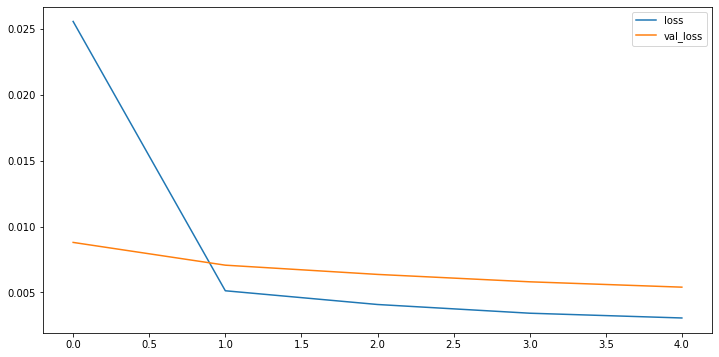

In [11]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(12,6))

# Convolutional Network

In [16]:
train_X, test_X, train_Y, test_Y = train_test_split(df.iloc[:,:-5], df.iloc[:,-5:], test_size=0.25, random_state=42)

train_X = train_X.stack().values.reshape(-1,8,11)
test_X = test_X.stack().values.reshape(-1,8,11)

train_Y = train_Y.droplevel(1, axis=1)
test_Y = test_Y.droplevel(1, axis=1)

scaler = Scaler()
scaler.fit(train_X)

In [17]:
# Params
batch_size = 64
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
      0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)
optimizer = keras.optimizers.Adam(lr_schedule)
loss = keras.losses.mean_squared_error

In [18]:
input_0 = layers.Input(shape=(8, 11, 1,))
x = layers.Conv2D(32, (3, 3), activation='selu')(input_0)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(50,activation ='selu')(x)

d1 = layers.Dense(1, activation='hard_sigmoid',
                  kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=keras.initializers.zeros(),
                  kernel_regularizer=keras.regularizers.l2(0.000001))(x)
d2 = layers.Dense(1, activation='hard_sigmoid',
                  kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=keras.initializers.zeros(),
                  kernel_regularizer=keras.regularizers.l2(0.000001))(x)
d3 = layers.Dense(1, activation='hard_sigmoid',
                  kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=keras.initializers.zeros(),
                  kernel_regularizer=keras.regularizers.l2(0.000001))(x)
d4 = layers.Dense(1, activation='hard_sigmoid',
                  kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=keras.initializers.zeros(),
                  kernel_regularizer=keras.regularizers.l2(0.000001))(x)
d5 = layers.Dense(1, activation='hard_sigmoid',
                  kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                  bias_initializer=keras.initializers.zeros(),
                  kernel_regularizer=keras.regularizers.l2(0.000001))(x)

x = layers.Concatenate(axis=1)([d1, d2, d3, d4, d5])

model_cnn = keras.models.Model(inputs=input_0, outputs=x, name='CNN')

model_cnn.compile(optimizer=optimizer, loss=loss)
model_cnn.summary()

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8, 11, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 9, 32)     320         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 3, 4, 32)     0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 384)          0           max_pooling2d_2[0][0]            
________________________________________________________________________________________________

In [19]:
history = model_cnn.fit(
    scaler.transform(train_X), scale_to_0_1(train_Y).values,
    validation_data= (scaler.transform(test_X), scale_to_0_1(test_Y).values),
    batch_size=batch_size,
    epochs=50,
    #callbacks =[early_stopping],
    #verbose=0,
)

Epoch 1/50
257/257 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 0.0067
Epoch 2/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 3/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 5/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
257/257 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0021

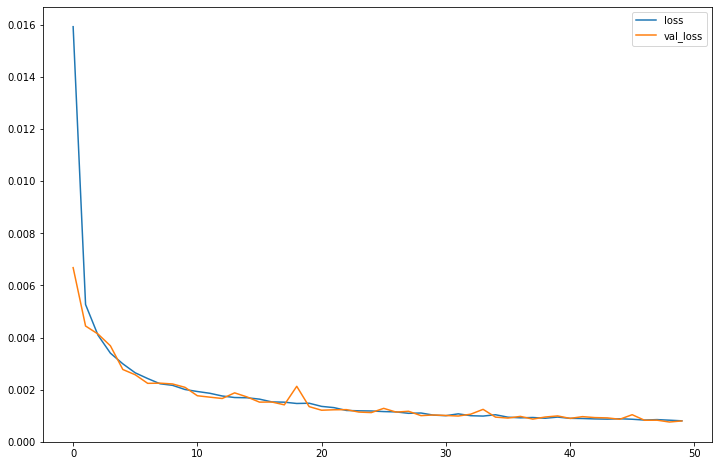

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(12,8));

# Interprability

In [65]:
import shap
import ipywidgets as widgets
shap.initjs()

In [116]:
explainer = shap.KernelExplainer(model = model_fcnn.predict, data = zca_process(train_X).head(50), link = "identity")

X_idx = 0
shap_value = explainer.shap_values(X = zca_process(train_X).head(50), nsamples = 100)

white reconstruction error: 2.6850222045737837e-10
white standardization error: 0.07662721434867259
white reconstruction error: 2.6850222045737837e-10
white standardization error: 0.07662721434867259


  0%|          | 0/50 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.419e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=3.901e-06, previous alpha=3.901e-06, with an active set of 45 regressors.
Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=1.245e-06, with an active set of 47 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=1.239e-06, with an active set of 47 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 79 

In [111]:
list_of_labels = train_Y.columns.get_level_values(0).values

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('v0', 0), ('rho', 1), ('sigma', 2), ('theta', 3), ('kappa', 4)…

Current Label Shown: theta

white reconstruction error: 2.6850222045737837e-10
white standardization error: 0.07662721434867259


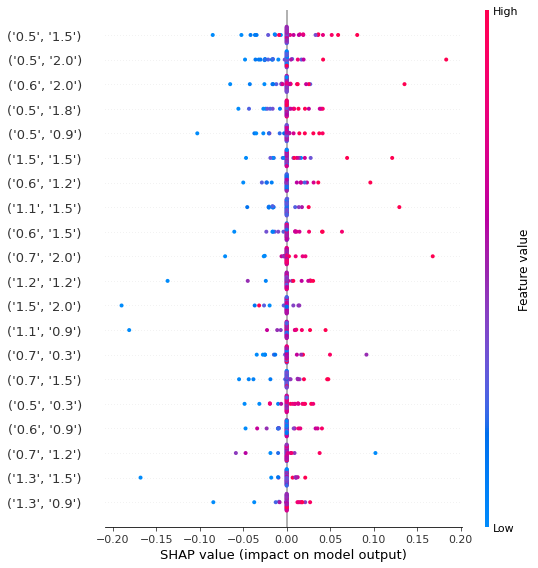

In [119]:
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values = shap_value[current_label.value],
                  features = zca_process(train_X).head(50)
                  )